<a href="https://colab.research.google.com/github/ShehabMohamed21/Image-Segmentation/blob/main/Image_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Import

In [ ]:
import numpy as np
import pandas as pd
import math
import cv2
from skimage import data
from skimage import io
from skimage.viewer import ImageViewer
import os
import re
from PIL import Image
import matplotlib.pyplot as plt
import gc
import random
import scipy.io
from PIL import Image as im
from collections import Counter
from sklearn.metrics import f1_score
from sklearn.metrics.cluster import contingency_matrix

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Viewer requires Qt
  import sys


##Mount google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##read data

In [ ]:
def read_images(directory):
  trainList = []
  for filename in sorted(os.listdir(directory)):
    #print(filename)
    img = cv2.imread(os.path.join(directory,filename))
    if (filename.endswith(".jpg")):      
      trainList.append(img)
  return trainList

In [ ]:
def read_groundTruth(directory):
  groundTruthList = []
  for filename in sorted(os.listdir(directory)):
    #print(filename)
    mat = scipy.io.loadmat(os.path.join(directory,filename))
    groundTruthList.append(mat['groundTruth'])
 
  return groundTruthList

In [ ]:
directory = "/content/drive/MyDrive/BSDS500/data/images/train"
trainImg = read_images(directory)

In [ ]:
directory = "/content/drive/MyDrive/BSDS500/data/images/test"
testImg = read_images(directory)

In [ ]:
directory = "/content/drive/MyDrive/BSDS500/data/groundTruth/train"
groundTruthList =  read_groundTruth(directory)

In [ ]:
directory = "/content/drive/MyDrive/BSDS500/data/groundTruth/test"
groundTruthList_test =  read_groundTruth(directory)

##View data

In [ ]:
def view_image(image):
  img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  plt.imshow(img)
  plt.show()

In [ ]:
def view_segmentation(segment):
  Segmentation = []
  Boundaries = []
  for i in range(segment.shape[1]):
    data1 = im.fromarray(segment[0,i][0,0][0])
    Segmentation.append(data1)
    data2 = im.fromarray(segment[0,i][0,0][1])
    Boundaries.append(data2)

  _, axs = plt.subplots(1, segment.shape[1], figsize=(12, 12))
  axs = axs.flatten()
  for img, ax in zip(Segmentation, axs):
      ax.imshow(img)
  plt.show()

  _, axs = plt.subplots(1, segment.shape[1], figsize=(12, 12))
  axs = axs.flatten()
  for img, ax in zip(Boundaries, axs):
    ax.imshow(img)
  plt.show()

In [ ]:
def view_single_sigmentation(array):
   data = im.fromarray(array)
   plt.imshow(data)
   plt.show()

In [ ]:
def convert_to_seg(one_d_array, shape):
  tmp = np.array(one_d_array, dtype=np.uint16)
  seg = np.reshape(tmp, (shape), order='C')
  return seg

In [ ]:
def save_clustered_colored_pic(centroids, labels, shape, filename):
  centers = np.uint8(centroids)
  data = centers[labels]
  data = data.reshape(shape)
  #save
  image = im.fromarray(data)
  image.save("/content/drive/MyDrive/BSDS500/data/Saved colored images/"+ filename + ".png")

In [ ]:
def plot_clustered_colored_pic(centroids, labels, shape):
  centers = np.uint8(centroids)
  data = centers[labels]
  data = data.reshape(shape)
  plt.imshow(data)

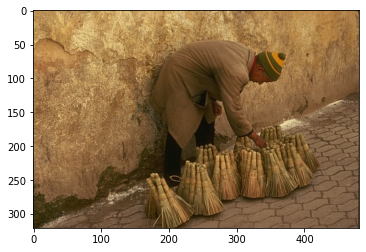

In [ ]:
view_image(trainImg[131])

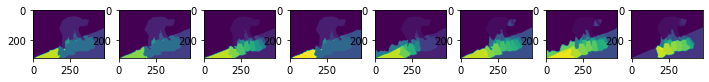

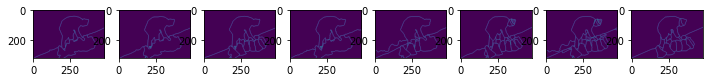

In [ ]:
view_segmentation(groundTruthList[131])

##understanding the nature of *segmentation*

In [ ]:
#array 1 * 8
groundTruthList[131]

array([[array([[(array([[1, 1, 1, ..., 1, 1, 1],
                       [1, 1, 1, ..., 1, 1, 1],
                       [1, 1, 1, ..., 1, 1, 1],
                       ...,
                       [1, 1, 1, ..., 3, 3, 3],
                       [1, 1, 1, ..., 3, 3, 3],
                       [1, 1, 1, ..., 3, 3, 3]], dtype=uint16), array([[0, 0, 0, ..., 0, 0, 0],
                       [0, 0, 0, ..., 0, 0, 0],
                       [0, 0, 0, ..., 0, 0, 0],
                       ...,
                       [0, 0, 0, ..., 0, 0, 0],
                       [0, 0, 0, ..., 0, 0, 0],
                       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))                                 ]],
              dtype=[('Segmentation', 'O'), ('Boundaries', 'O')])                                 ,
        array([[(array([[1, 1, 1, ..., 1, 1, 1],
                       [1, 1, 1, ..., 1, 1, 1],
                       [1, 1, 1, ..., 1, 1, 1],
                       ...,
                       [1, 1, 1, ..., 3, 3,

In [ ]:
((groundTruthList[10][0,1][0,0][0]))

array([[1, 1, 1, ..., 3, 3, 3],
       [1, 1, 1, ..., 2, 2, 2],
       [1, 1, 1, ..., 2, 2, 2],
       ...,
       [4, 4, 4, ..., 6, 6, 6],
       [4, 4, 4, ..., 6, 6, 6],
       [4, 4, 4, ..., 6, 6, 6]], dtype=uint16)

In [ ]:
(groundTruthList[10][0,1][0,0][0]).shape

(321, 481)

# Kmeans

In [ ]:
def assignToCluster(pixel, centroids):
  tmp = []

  for i in range (0, len(centroids)):
    tmp.append(np.sqrt(np.sum(np.square(np.subtract(np.array(pixel), np.array(centroids[i]))))))
    
  return tmp.index(min(tmp))

In [ ]:
def updateCentroids(clusters):
  newCentroids = []

  for i in range (0, len(clusters)):
    newCentroids.append(np.sum(clusters[i], axis = 0) / len(clusters[i]))
  
  return newCentroids

In [ ]:
def generateCentroids(D, k):
  centroids = []
  indices = []
  while (len(centroids) < k):
    x = random.randint(0, len(D)-1)
    if x not in indices:
      centroids.append(D[x])
      indices.append(x)
  
  return centroids

In [ ]:
kValues = [3, 5, 7, 9, 11]

def kMeans(D, k, e):
  #centroids = np.random.rand(k, 2)
  centroids = generateCentroids(D,k)
  #centroids = [2, 4]
  #centroids = [[2, 2], [1,4], [4,3]]
  while (True):
    clusters = []
    clusterPoints = []

    for i in range(0,k):
      clusterPoints.append([])

    # loop on every pixel in data and calculate the distance with centroids then assign this image to nearest centroid
    for i in range(0, len(D)):
      clusters.append(assignToCluster(D[i],centroids))
      clusterPoints[assignToCluster(D[i], centroids)].append(D[i])
    
    dataCounter = dict(Counter(clusters))
    
    #check if there is update to new centroids

    # np.subtract(x1, x2) for (x1, x2) in zip(List1, List2) (new way)
    # sum(np.square(np.array(new_centroids) - np.array(centroids))) (old way)
    
    if(len(dataCounter) < k):
      centroids = generateCentroids(D,k)
    else:
      new_centroids = updateCentroids(clusterPoints)
      if(np.sum(np.square(np.subtract(np.array(new_centroids),np.array(centroids)))) < e):
        break
      else: 
        centroids = new_centroids
  return clusters, centroids

##run k means

In [ ]:
pixel_vals = trainImg[3].reshape((-1,3))
 
# Convert to float type
pixel_vals = np.float32(pixel_vals)

In [ ]:
d = np.array((pixel_vals))
#d = [2,3,4,10,11,12,20,25,30]
#d = np.array(d)

#d =  [[2,2], [1,14], [10,7], [1,11], [3,4], [11,8], [4,3], [12,9]]
new_data, nCentroids = kMeans(d, 3, 0.00001)

In [ ]:
# view seg as 2d array to pic
seg = convert_to_seg(new_data,(trainImg[3].shape[0],trainImg[3].shape[1]))
view_single_sigmentation(seg)

In [ ]:
# save and show colored pic
save_clustered_colored_pic(nCentroids, new_data, trainImg[3].shape, "testpic")
plot_clustered_colored_pic(nCentroids, new_data, trainImg[3].shape)

##test with built in k-means


In [ ]:
from sklearn.cluster import KMeans
pixel_vals = trainImg[5].reshape((-1,3))
# Convert to float type
pixel_vals = np.float32(pixel_vals)
d = np.array((pixel_vals))
kmeans = KMeans(n_clusters=5, random_state=0).fit(d)

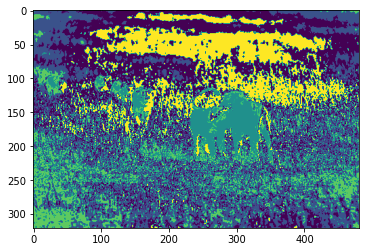

In [ ]:
# view seg as 2d array to pic
test_seg = convert_to_seg(kmeans.labels_,(trainImg[3].shape[0],trainImg[3].shape[1]))
view_single_sigmentation(test_seg)  

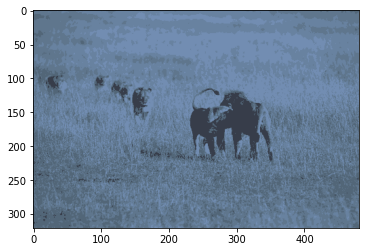

In [ ]:
#show colored pic in 3d 
plot_clustered_colored_pic(kmeans.cluster_centers_, kmeans.labels_, trainImg[3].shape)

##Evaluation of Clustring

In [ ]:
def calc_F_measure(true, pred):
  F_measures = []
  for i in range(true.shape[1]):
    groundTruth = (true[0,i][0,0][0]).flatten(order='C')
    f_measure = f1_score(groundTruth, pred, average='weighted')
    F_measures.append(f_measure)
  
  avg = sum(F_measures) / len(F_measures)

  return F_measures, avg

In [ ]:
def calc_entropy(true, pred):
  entropy_measures = []

  for i in range(true.shape[1]):
    groundTruth = (true[0,i][0,0][0]).flatten(order='C')
    matrix = contingency_matrix(groundTruth, pred)
    entr_meas = calculate(matrix)
    entropy_measures.append(entr_meas)

  avg = sum(entropy_measures) / len(entropy_measures)

  return entropy_measures, avg

In [ ]:
def calculate(matrix):
  rows = matrix.shape[0]
  columns = matrix.shape[1]
  cond_entr = 0
  total_sum = np.sum(matrix)
  for j in range (columns):
    sum = np.sum(matrix[:,j])
    entr = 0
    for i in range (rows):
      p = matrix[i][j] / sum
      if(p != 0):
        entr = entr + -1 * p * math.log10(p)
    cond_entr = cond_entr + (sum/total_sum) * entr

  return cond_entr

In [ ]:
calc_F_measure(groundTruthList[5], new_data)

([0.6356259960965914,
  0.6383546594282624,
  0.6375242013998853,
  0.6355647275753503,
  0.6358008767024639,
  0.6345280319576261],
 0.6362330821933632)

##run on 50 pics of test set

In [ ]:
k = 7

for i in range(50):
  pixel_vals = testImg[i].reshape((-1,3)) 
  # Convert to float type
  pixel_vals = np.float32(pixel_vals)
  d = np.array((pixel_vals))
  new_data, nCentroids = kMeans(d, k, 0.00001)
  
  save_clustered_colored_pic(nCentroids, new_data, testImg[i].shape, "/k" + str(k) + "/" + str(i))

  f = open("/content/drive/MyDrive/BSDS500/data/Saved colored images/k" + str(k) +"/k" + str(k) + ".txt", "a")

  F_measures, avg_F = calc_F_measure(groundTruthList_test[i], new_data)
  f.write("F_measure : " + str(F_measures) + str(avg_F) + "\n")
  
  entropy_measures, avg_enropy = calc_entropy(groundTruthList_test[i], new_data)
  
  f.write("cond_entropy : " + str(entropy_measures) + str(avg_enropy) + "\n")
  f.close()

# Big Picture

A

In [ ]:
#a
for i in range(5):
  print("Image number ",i+1," : ")
  image = trainImg[i]
  view_image(image)
  view_segmentation(groundTruthList[i])
  print("\n------------------------------------------------------------\n")
  pixel = image.reshape((-1,3))
  pixel = np.float32(pixel)
  new_data, nCentroids = kMeans(np.array((pixel)), 5, 0.00001)
  seg = convert_to_seg(new_data,(image.shape[0],image.shape[1]))
  view_single_sigmentation(seg)
  plot_clustered_colored_pic(nCentroids, new_data, image.shape)
  print("\n/////////////////////////////////////////////////////////////\n")

B

In [ ]:
#b
from sklearn.cluster import SpectralClustering
for i in range(5):
  print("Image number ",i+1," : ")
  image = trainImg[i]
  view_image(image)
  view_segmentation(groundTruthList[i])
  print("\n------------------------------------------------------------\n")
  pixel = image.reshape((-1,3))
  pixel = np.float32(pixel)
  clustering = SpectralClustering(n_clusters=5,random_state=1,affinity='nearest_neighbors',n_neighbors=5).fit(np.array(pixel))
  seg = convert_to_seg(clustering.labels_,(image.shape[0],image.shape[1]))
  view_single_sigmentation(seg)
  print("\n/////////////////////////////////////////////////////////////\n")